<a href="https://colab.research.google.com/github/earo12/Payments_Fraud_Detection/blob/main/Online_Payments_Fraud_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns 

In [2]:
df = pd.read_csv('PS.csv')
df.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0.0,0.0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0.0,0.0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1.0,0.0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1.0,0.0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0.0,0.0


In [5]:
df.isnull().sum()

step              0
type              0
amount            0
nameOrig          0
oldbalanceOrg     0
newbalanceOrig    0
nameDest          0
oldbalanceDest    1
newbalanceDest    1
isFraud           1
isFlaggedFraud    1
dtype: int64

Here whe can see we have some null values at the data frame, after I checked all of them I found that every NaN value was followed by a zero, so I'll fill them with a zero as well

In [22]:
df['oldbalanceDest'].fillna(0,inplace = True)

In [23]:
df['newbalanceDest'].fillna(0,inplace = True)
df['isFraud'].fillna(0, inplace = True)
df['isFlaggedFraud'].fillna(0, inplace = True)

Let's take a look into each attribute of the DataFrame

In [26]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 165439 entries, 0 to 165438
Data columns (total 11 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   step            165439 non-null  int64  
 1   type            165439 non-null  object 
 2   amount          165439 non-null  float64
 3   nameOrig        165439 non-null  object 
 4   oldbalanceOrg   165439 non-null  float64
 5   newbalanceOrig  165439 non-null  float64
 6   nameDest        165439 non-null  object 
 7   oldbalanceDest  165439 non-null  float64
 8   newbalanceDest  165439 non-null  float64
 9   isFraud         165439 non-null  float64
 10  isFlaggedFraud  165439 non-null  float64
dtypes: float64(7), int64(1), object(3)
memory usage: 13.9+ MB


From here we can see there are three attributes wich are not specifically numbers, let's take a look deeper in them

In [29]:
df['type'].value_counts()

PAYMENT     62238
CASH_OUT    54182
CASH_IN     33762
TRANSFER    13779
DEBIT        1478
Name: type, dtype: int64

In [30]:
df['oldbalanceDest'].value_counts()

0.00         73267
102.00           9
103.00           7
108.00           6
156.00           6
             ...  
197601.30        1
663827.10        1
99908.25         1
795191.59        1
11507.00         1
Name: oldbalanceDest, Length: 90918, dtype: int64

In [31]:
df['newbalanceDest'].value_counts()

0.00           72927
971418.91         32
19169204.93       29
1254956.07        25
16532032.16       25
               ...  
106384.75          1
128827.44          1
41252.59           1
363403.20          1
137631.63          1
Name: newbalanceDest, Length: 39110, dtype: int64

As we see, we only have five rows from the attribute type, let's check them as a plot and see if we can find something interesting

In [40]:
values_df = df['type'].value_counts()

Index(['PAYMENT', 'CASH_OUT', 'CASH_IN', 'TRANSFER', 'DEBIT'], dtype='object')
[62238 54182 33762 13779  1478]


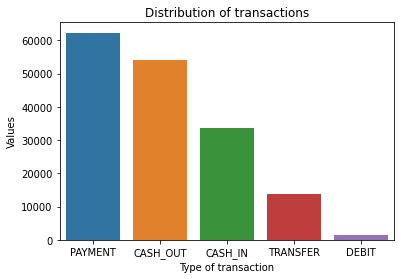

In [43]:
sns.barplot(data = df, x = values_df.index, y = values_df.values)
plt.xlabel('Type of transaction')
plt.ylabel('Values')
plt.title('Distribution of transactions')
plt.show()

From here, we can see many of the data it's with PAYMENT as a type of transaction, so let's check now whether there is a correlation from each attribute in the DataFrame that can tell us something related with isFraud field.

To do that, we can us the corr method in the DataFrame.

In [54]:
df.corr()

,step,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
step,1.000000,0.055731,-0.006090,-0.005804,0.020462,0.006950,-0.044940,NaN
amount,0.055731,1.000000,-0.018342,-0.023154,0.226718,0.352507,0.036147,NaN
oldbalanceOrg,-0.006090,-0.018342,1.000000,0.998971,0.096140,0.065276,-0.002860,NaN
newbalanceOrig,-0.005804,-0.023154,0.998971,1.000000,0.097667,0.064260,-0.008740,NaN
oldbalanceDest,0.020462,0.226718,0.096140,0.097667,1.000000,0.948776,-0.008267,NaN
newbalanceDest,0.006950,0.352507,0.065276,0.064260,0.948776,1.000000,-0.005301,NaN
isFraud,-0.044940,0.036147,-0.002860,-0.008740,-0.008267,-0.005301,1.000000,NaN
isFlaggedFraud,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Let's view the last shell in a heat map 

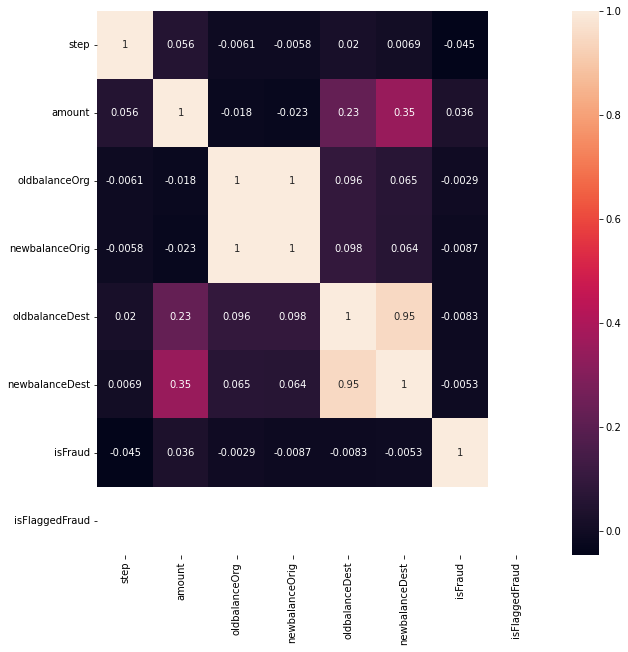

In [56]:
plt.rcParams['figure.figsize'] = (10,10)
sns.heatmap(data = df.corr(), annot = True)
plt.show()